In [ ]:
from fastai.vision.all import *
np.random.seed(4682)

In [ ]:
# path=untar_data(URLs.CAMVID_TINY)
path=untar_data(URLs.CAMVID)

path.ls()

(#4) [Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/labels')]

In [ ]:
path_imgs=path/'images'
path_labels=path/'labels'

In [ ]:
fnames=get_image_files(path_imgs)
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid/images/0016E5_00810.png'),Path('/root/.fastai/data/camvid/images/0016E5_07200.png'),Path('/root/.fastai/data/camvid/images/Seq05VD_f00390.png')]

In [ ]:
labelnames=get_image_files(path_labels)
labelnames[:3]

(#3) [Path('/root/.fastai/data/camvid/labels/0016E5_00510_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_06000_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_08250_P.png')]

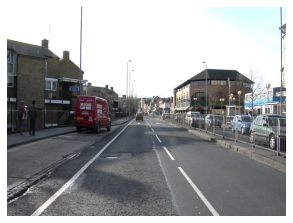

In [ ]:
PILImage.create(fnames[0]).show(figsize=(5,5))

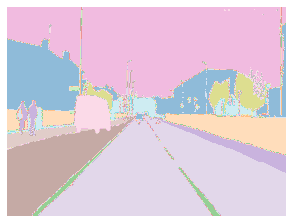

In [ ]:
get_label_file=lambda x:path_labels/f"{x.stem}_P{x.suffix}"
PILMask.create(get_label_file(fnames[0])).show(figsize=(5,5))

In [ ]:
# PILImage.create(fnames[0]).shape,PILMask.create(get_label_file(fnames[0])).shape
image_shape=PILImage.create(fnames[0]).shape
image_shape

(720, 960)

In [ ]:
codes=np.loadtxt(path/"codes.txt",dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
len(codes)

32

image_size: (180, 240)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


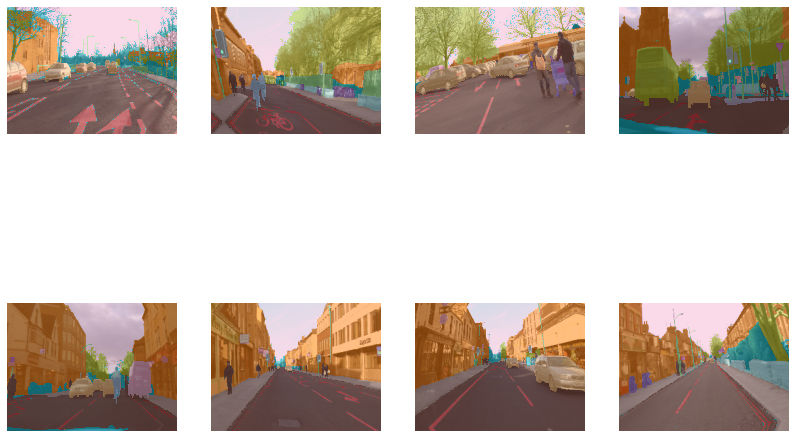

In [ ]:
def get_dls(scaling_factor=4,bs=8):
  image_shape=PILImage.create(fnames[0]).shape
  image_shape=tuple(s//scaling_factor for s in image_shape)
  print("image_size:",image_shape)
  dblock=DataBlock(blocks=[ImageBlock,MaskBlock(codes)],
        batch_tfms=[*aug_transforms(size=image_shape,mult=1),Normalize.from_stats(*imagenet_stats)],
        get_y=get_label_file,
        splitter=RandomSplitter(0.2,6751)
  )
  # ds=dblock.datasets(fnames)
  # print(ds[0])
  # del ds
  dls=dblock.dataloaders(fnames,bs=bs)
  return dls

dls=get_dls(scaling_factor=4,bs=8)
dls.train.show_batch(figsize=(14,10))

In [ ]:
dls.vocab = codes

In [ ]:
name2id={code:i for i,code in enumerate(codes)}
void_idx=name2id['Void']

def acc_camvid(input,target):
  target = target.squeeze(1)
  mask = target != void_idx
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
learn=unet_learner(dls,models.resnet34,metrics=acc_camvid,wd=1e-2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The cur

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.fit_one_cycle(11)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.479303,0.954210,0.780947,00:28
1,0.960907,0.781334,0.811713,00:28
2,0.725256,0.633410,0.839483,00:29
3,0.624948,0.550207,0.863223,00:29
4,0.555867,0.495308,0.869921,00:29
5,0.492102,0.447422,0.880943,00:29
6,0.443934,0.435864,0.884120,00:28
7,0.415727,0.394342,0.896489,00:29
8,0.381622,0.369595,0.900414,00:30
9,0.354552,0.357222,0.902009,00:30


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save('stage-1-scale_factor-4')

Path('models/stage-1-scale_factor-4.pth')

In [ ]:
# learn.load('stage-1-scale_factor-4')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=2.0892961401841603e-05)

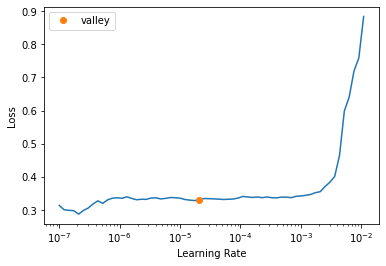

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(8,lr_max=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.335530,0.353262,0.903671,00:31
1,0.334543,0.352810,0.902827,00:30
2,0.330960,0.347052,0.905003,00:30
3,0.324712,0.344944,0.905018,00:30
4,0.318478,0.342319,0.905058,00:30
5,0.315166,0.338391,0.906355,00:31
6,0.311864,0.338037,0.906956,00:31
7,0.311901,0.338236,0.906718,00:30


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save('stage-2-scale_factor-4')

Path('models/stage-2-scale_factor-4.pth')

image_size: (360, 480)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


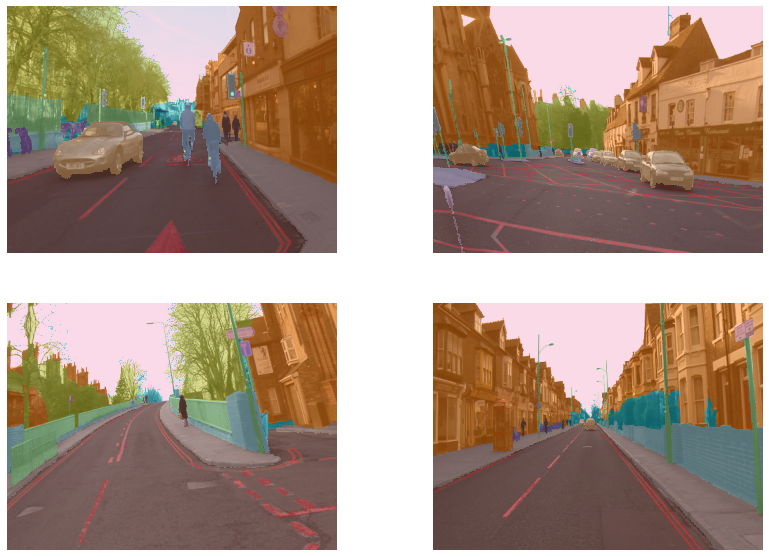

In [ ]:
dls=get_dls(scaling_factor=2,bs=8)
dls.train.show_batch(max_n=4,figsize=(14,10))

In [ ]:
learn=unet_learner(dls,models.resnet34,metrics=acc_camvid,wd=1e-2)
learn.load("stage-2-scale_factor-4")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The cur

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=7.585775892948732e-05)

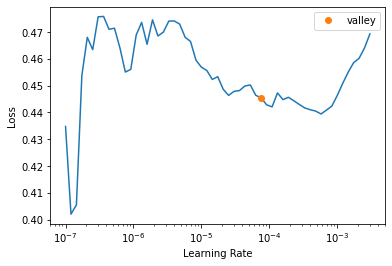

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(11,lr_max=slice(7.585775892948732e-05),cbs=[SaveModelCallback(fname='best_model'),EarlyStoppingCallback(patience=3)])

epoch,train_loss,valid_loss,acc_camvid,time
0,0.418859,0.382255,0.897146,01:27
1,0.376463,0.356899,0.903993,01:26
2,0.356069,0.350190,0.902169,01:26
3,0.341494,0.331179,0.909630,01:26
4,0.325384,0.316083,0.911949,01:26
5,0.311049,0.315440,0.912491,01:26
6,0.303931,0.307408,0.914858,01:26
7,0.293641,0.305403,0.915385,01:26
8,0.290351,0.300631,0.915613,01:26
9,0.284046,0.298796,0.917462,01:26


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 0.38225534558296204.
Better model found at epoch 1 with valid_loss value: 0.3568994104862213.
Better model found at epoch 2 with valid_loss value: 0.3501899242401123.
Better model found at epoch 3 with valid_loss value: 0.3311789631843567.
Better model found at epoch 4 with valid_loss value: 0.31608280539512634.
Better model found at epoch 5 with valid_loss value: 0.3154401481151581.
Better model found at epoch 6 with valid_loss value: 0.30740758776664734.
Better model found at epoch 7 with valid_loss value: 0.3054027557373047.
Better model found at epoch 8 with valid_loss value: 0.30063071846961975.
Better model found at epoch 9 with valid_loss value: 0.29879555106163025.


In [ ]:
# learn.load('best_model')
learn.save('stage-1-scale_factor-2')

Path('models/stage-1-scale_factor-2.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=1.2022644114040304e-05)

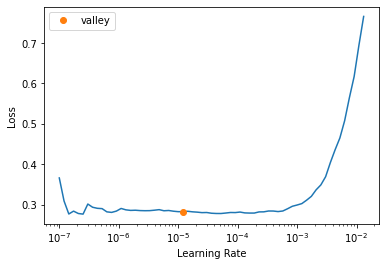

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.load('stage-1-scale_factor-2')
learn.unfreeze()

In [ ]:
# learn.fit_one_cycle(8,lr_max=slice(1e-6,3e-5),cbs=[SaveModelCallback(fname='best_model'),EarlyStoppingCallback(patience=2)])
learn.fit_one_cycle(8,lr_max=slice(5e-6,1e-4),cbs=[SaveModelCallback(fname='best_model'),EarlyStoppingCallback(patience=2)])

epoch,train_loss,valid_loss,acc_camvid,time
0,0.286905,0.299875,0.916986,01:30
1,0.291313,0.300735,0.917572,01:29
2,0.290138,0.296057,0.917140,01:29
3,0.274247,0.287594,0.919241,01:29
4,0.263094,0.277428,0.924432,01:30
5,0.251277,0.271815,0.925856,01:29
6,0.241998,0.270359,0.925122,01:29
7,0.241334,0.271013,0.925371,01:29


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 0.2998752295970917.
Better model found at epoch 2 with valid_loss value: 0.29605668783187866.
Better model found at epoch 3 with valid_loss value: 0.2875937521457672.
Better model found at epoch 4 with valid_loss value: 0.2774279713630676.
Better model found at epoch 5 with valid_loss value: 0.2718147039413452.
Better model found at epoch 6 with valid_loss value: 0.2703593373298645.


In [ ]:
learn.save("stage-2-scale_factor-2")  

Path('models/stage-2-scale_factor-2.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


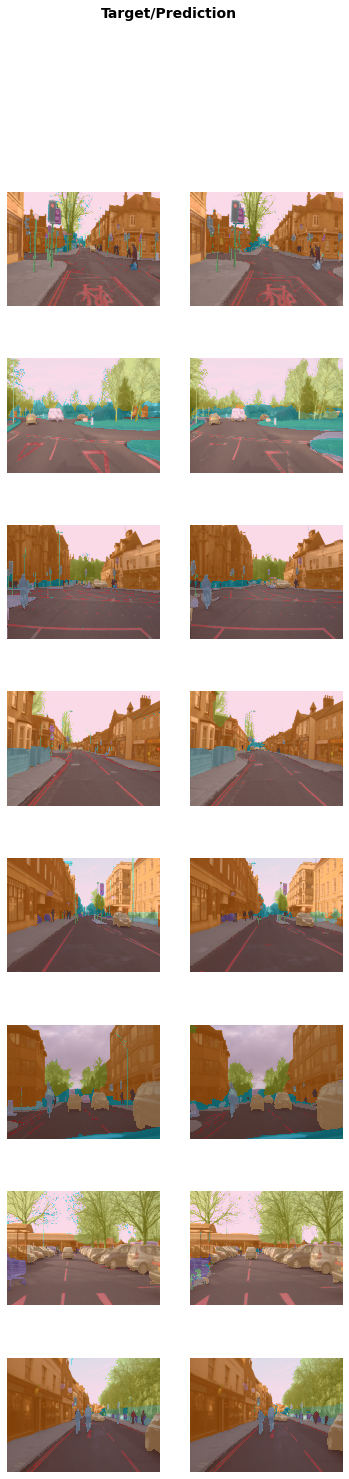

In [ ]:
learn.show_results()

In [ ]:
learn.load("stage-2-scale_factor-2")

In [ ]:
# test_img="car.png"
# test_img="car2.jpg"
# test_img="car3.jpg"
# test_img="car4.jpg"
test_img="car5.webp"
test_pred=learn.predict(test_img)[0]

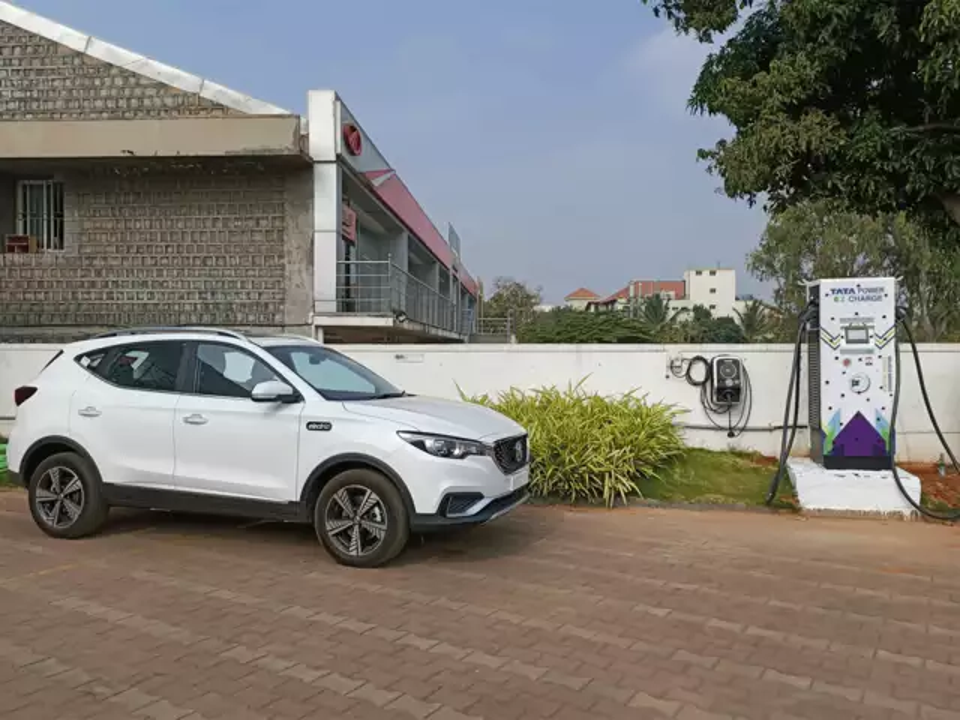

In [ ]:
PILImage.create(test_img).resize((image_shape[1],image_shape[0]))

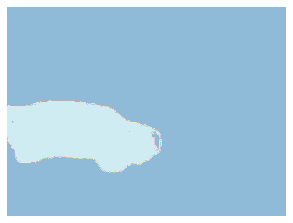

In [ ]:
PILMask.create((test_pred==name2id['Car'])).show()

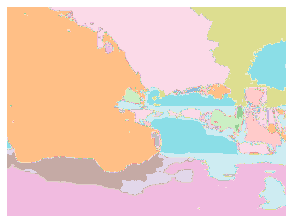

In [ ]:
PILMask.create(test_pred).show()

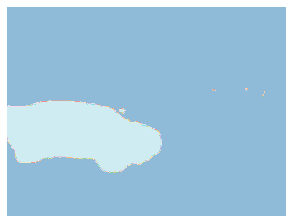

In [ ]:
def get_filtered_mask(labels_list):
  new_labels=torch.zeros_like(test_pred)
  for label in labels_list:
    new_labels+=(test_pred==name2id[label])
  new_labels=(new_labels>=1).float()
  return new_labels
# PILMask.create(((test_pred==name2id['Car'])+(test_pred==name2id['SUVPickupTruck']))>=1).show()
mask=get_filtered_mask(['Car','SUVPickupTruck','Truck_Bus'])
PILMask.create(mask).show()

In [ ]:
# name2id

In [ ]:
img=tensor(PILImage.create(test_img).resize(tuple(mask.shape)[::-1]))
img.shape

torch.Size([360, 480, 3])

In [ ]:
mask=mask.unsqueeze(-1).repeat(1,1,3)
mask.shape

torch.Size([360, 480, 3])

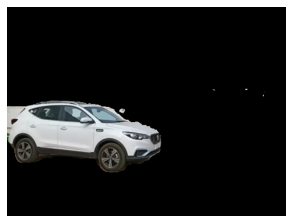

In [ ]:
PILImage.create(img*mask).show()